In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.metrics import root_mean_squared_error

In [21]:
stores_df = pd.read_csv('store.csv')
#test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv', low_memory=False)

In [22]:
print(f"Data ranges from {train_df["Date"].min()} to {train_df["Date"].max()}")
print(f"Data comes from {train_df["Store"].nunique()} stores")
print(f"Missing values are distributed as follows: \n{stores_df.isna().sum()}")

Data ranges from 2013-01-01 to 2015-07-31
Data comes from 1115 stores
Missing values are distributed as follows: 
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


Time series per store

In [23]:
# Remove all rows with Open == 0
train_df = train_df[train_df["Open"] != 0]
train_df.drop(columns=["Open"], inplace=True)

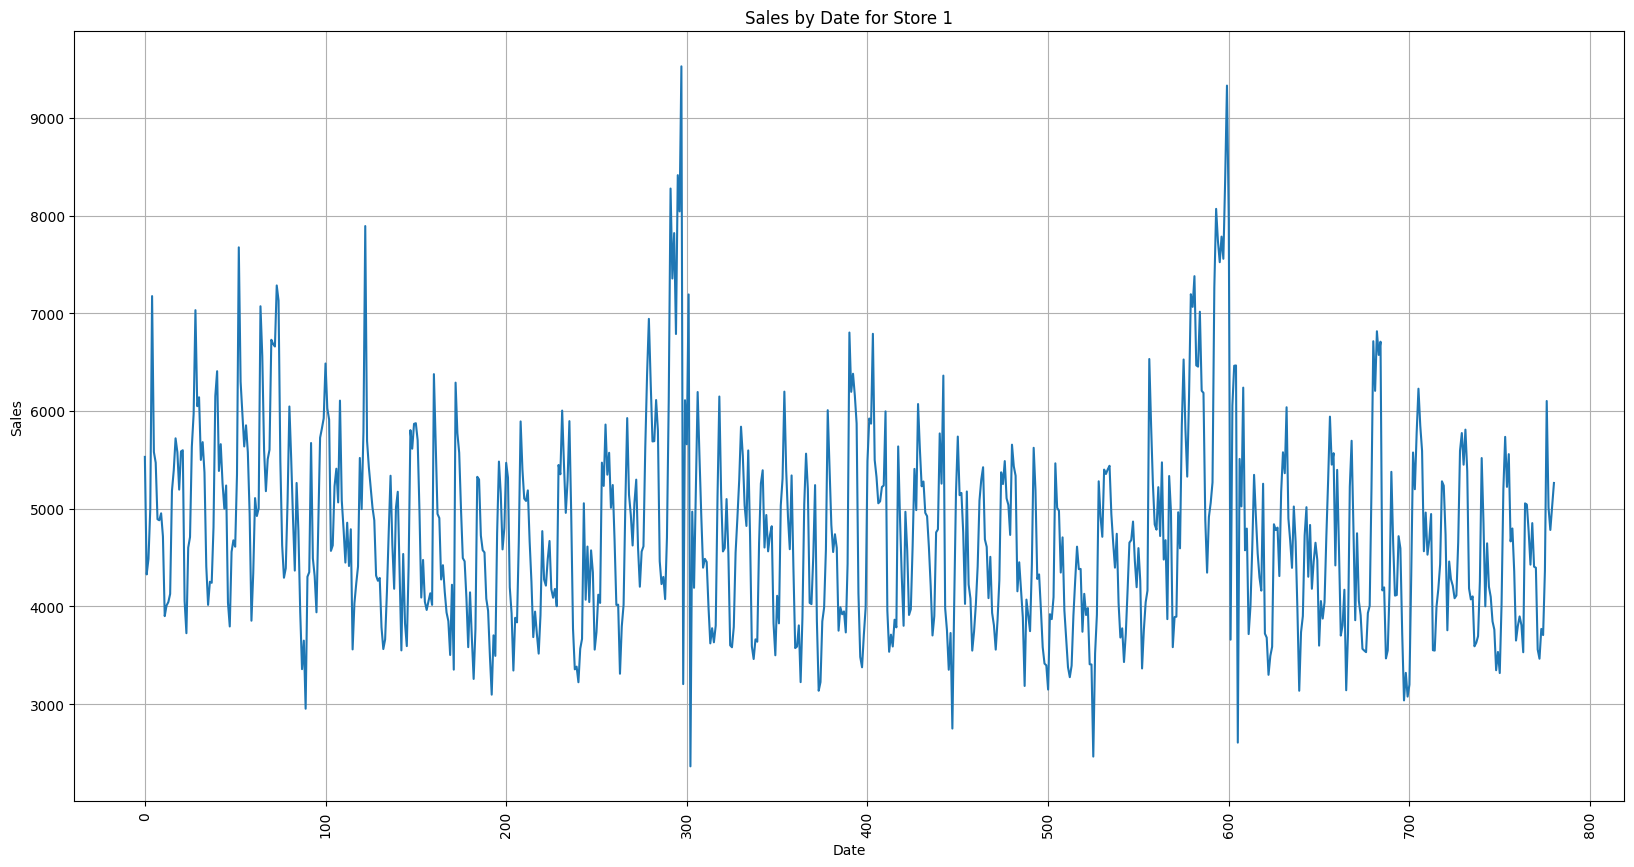

In [24]:
def plot_store_time_series(store_id, train_df):
    store_data = train_df[train_df['Store'] == store_id]
    x = np.arange(len(store_data['Date'].unique()))
    y = store_data.groupby('Date')['Sales'].sum()

    plt.figure(figsize=(20, 10))
    plt.plot(x, y)
    plt.title(f'Sales by Date for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=90)
    plt.grid()
    plt.savefig(f'time_series_plot.png')
    plt.show()

plot_store_time_series(1, train_df)

Outliers identification using z-score

In [25]:
def identify_outliers(train_df):
    df = train_df.copy()

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Store', 'Date'])
    window = 7

    df['rolling_mean'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['rolling_std'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # Avoid division by zero (std can be 0 in early days)
    df['rolling_std'] = df['rolling_std'].replace(0, np.nan)

    df['z_score'] = (df['Sales'] - df['rolling_mean']) / df['rolling_std']
    df['is_outlier'] = df['z_score'].abs() > 2
    df.reset_index(drop=True, inplace=True)

    outliers = df[df['is_outlier'] == True]
    print(outliers[['Date', 'Store', 'Sales', 'z_score']])

    return df

df = identify_outliers(train_df)

             Date  Store  Sales   z_score
22     2013-01-28      1   4055 -2.166048
52     2013-03-04      1   7675  2.094888
64     2013-03-18      1   7072  2.027046
103    2013-05-06      1   4568 -2.063948
115    2013-05-22      1   3559 -2.005410
...           ...    ...    ...       ...
844291 2015-03-30   1115  11641  2.054756
844351 2015-06-15   1115  10853  2.021938
844363 2015-06-29   1115  11006  2.189264
844375 2015-07-13   1115  10598  2.125102
844387 2015-07-27   1115  10712  2.157304

[37127 rows x 4 columns]


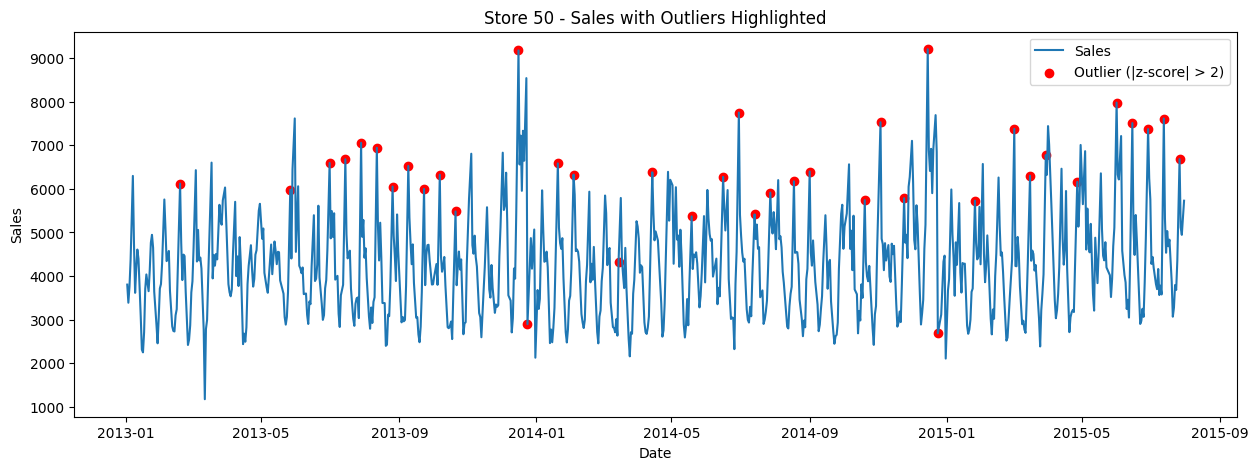

In [26]:
def filter_store(id):
    store_data = train_df[train_df['Store'] == id]
    store_data = store_data[['Date', 'Sales', 'Customers', 'StateHoliday', 'SchoolHoliday']]
    store_data['Date'] = pd.to_datetime(store_data['Date'])
    store_data = store_data.groupby('Date')
    return store_data

def plot_outliers(store_id, df):
    # Use df, which contains z_score and is_outlier columns
    store_data = df[df['Store'] == store_id].copy()
    plt.figure(figsize=(15, 5))
    plt.plot(store_data['Date'], store_data['Sales'], label='Sales')
    # Plot outliers (z_score > 2 or < -2)
    outlier_mask = store_data['is_outlier']
    plt.scatter(store_data.loc[outlier_mask, 'Date'], 
                store_data.loc[outlier_mask, 'Sales'], 
                color='red', label='Outlier (|z-score| > 2)')
    plt.legend()
    plt.title(f"Store {store_id} - Sales with Outliers Highlighted")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.savefig("Outliers.png")
    plt.show()

plot_outliers(50, df)

It looks like the only outliers are identified when sales are equal to 0. Let's identify the reason

In [28]:
zero_sales = train_df[train_df['Sales'] == 0]
print(zero_sales[['Date', 'Store', 'Sales', 'Customers', 'StateHoliday', 'SchoolHoliday']])

customers = zero_sales[zero_sales['Customers'] > 0]
print(customers[['Date', 'Store', 'Sales', 'Customers', 'StateHoliday', 'SchoolHoliday']])

              Date  Store  Sales  Customers StateHoliday  SchoolHoliday
86825   2015-05-15    971      0          0            0              1
142278  2015-03-26    674      0          0            0              0
196938  2015-02-05    699      0          0            0              0
322053  2014-10-01    708      0          0            0              0
330176  2014-09-22    357      0          0            0              0
340348  2014-09-11    227      0          0            0              0
340860  2014-09-11    835      0          0            0              0
341795  2014-09-10    835      0          0            0              0
346232  2014-09-05    548      0          0            0              1
346734  2014-09-04     28      0          0            0              0
347669  2014-09-03     28      0          0            0              1
348604  2014-09-02     28      0          0            0              1
386065  2014-07-24    102      0          0            0        

Each time sales are zero is because there are no customers, except for two occasions with 5 and 3 customers. There aren't particular outliers to take into account.

In [29]:
median_year = int(stores_df['CompetitionOpenSinceYear'].median())
stores_df.fillna({'CompetitionOpenSinceYear': median_year}, inplace=True)

stores_df.fillna({'CompetitionOpenSinceMonth' : np.random.randint(1, 13)}, inplace=True)
stores_df.fillna({'CompetitionDistance' : 0}, inplace=True)
print(f"Check missing values again after filling: \n{stores_df.isna().sum()}")

Check missing values again after filling: 
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


Merging the two files for a richer dataset

In [30]:
final_df = train_df.merge(stores_df, on="Store", how="left")
display(final_df.head())

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Boxplots for holidays and promotions

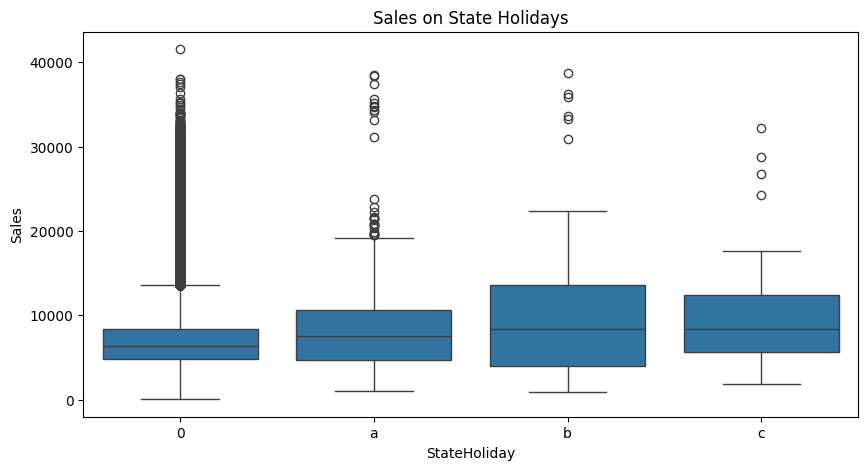

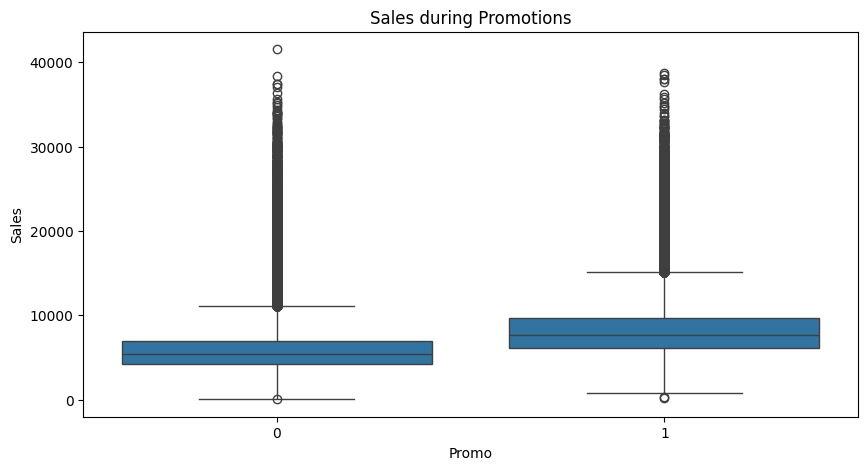

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=final_df[final_df['Sales'] > 0], x='StateHoliday', y='Sales')
plt.title('Sales on State Holidays')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=final_df[final_df['Sales'] > 0], x='Promo', y='Sales')
plt.title('Sales during Promotions')
plt.show()

In [32]:
final_df = final_df.sort_values(['Store', 'Date'])
lags = [1, 7, 14]

for lag in lags:
    final_df[f'Sales_lag_{lag}'] = final_df.groupby('Store')['Sales'].shift(lag)

final_df = final_df.dropna(subset=[f'Sales_lag_{lag}' for lag in lags])
final_df['Sales_ma_7'] = final_df.groupby('Store')['Sales'].shift(1).rolling(window=7).mean()
final_df['Sales_ma_14'] = final_df.groupby('Store')['Sales'].shift(1).rolling(window=14).mean()

display(final_df.head(10))
final_df.to_csv('final_df.csv', index=False)

print(final_df.columns)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_ma_7,Sales_ma_14
827744,1,5,2013-01-18,4127,568,0,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,4044.0,4892.0,5530.0,NaN,NaN
826637,1,6,2013-01-19,5182,688,0,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,4127.0,4881.0,4327.0,NaN,NaN
825511,1,1,2013-01-21,5394,607,1,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5182.0,4952.0,4486.0,NaN,NaN
824404,1,2,2013-01-22,5720,667,1,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5394.0,4717.0,4997.0,NaN,NaN
823297,1,3,2013-01-23,5578,627,1,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5720.0,3900.0,7176.0,NaN,NaN
822189,1,4,2013-01-24,5195,645,1,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5578.0,4008.0,5580.0,NaN,NaN
821081,1,5,2013-01-25,5586,676,1,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5195.0,4044.0,5471.0,NaN,NaN
819973,1,6,2013-01-26,5598,640,0,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5586.0,4127.0,4892.0,5254.571429,NaN
818846,1,1,2013-01-28,4055,549,0,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,5598.0,5182.0,4881.0,5464.714286,NaN
817739,1,2,2013-01-29,3725,522,0,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,4055.0,5394.0,4952.0,5303.714286,NaN


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Sales_lag_1', 'Sales_lag_7',
       'Sales_lag_14', 'Sales_ma_7', 'Sales_ma_14'],
      dtype='object')


In [ ]:
def split_dataset(final_df):
    feature_cols = [
        'Store',
        "Customers",
        'Promo',
        'Promo2', #TODO separare da store con gli intervalli
        'DayOfWeek', # da rimuovere
        'Sales_lag_1',
        'Sales_lag_7',
        'Sales_lag_14',
        'Sales_ma_7', 
        'Sales_ma_14',
    ]

    cols_to_drop = [
        'SchoolHoliday',
        'StateHoliday',
        'Assortment', # modifica con etichette
        'StoreType', 
        'CompetitionOpenSinceMonth', 
        'CompetitionOpenSinceYear',
        'CompetitionDistance',
        'PromoInterval',
        'Promo2SinceYear',
        'Promo2SinceWeek',
    ]

    df_model = final_df.dropna(subset=feature_cols + ['Sales'])
    df_model = df_model.drop(columns=cols_to_drop)

    train = df_model[df_model['Date'] < '2015-03-01']
    train = train.drop(columns='Date')
    test = df_model[df_model['Date'] >= '2015-03-01']
    test = test.drop(columns='Date')

    X_train, y_train = train[feature_cols], train['Sales']
    X_test, y_test = test[feature_cols], test['Sales']

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = split_dataset(final_df)

In [34]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

In [35]:
import json

try:
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)
except FileNotFoundError:
    best_params = None    

if not best_params:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 447, 'max_depth': 12, 'learning_rate': 0.04149121313555808, 'subsample': 0.8945442673384523, 'colsample_bytree': 0.607458416355693, 'min_child_weight': 7, 'gamma': 3.574921960310958, 'reg_alpha': 1.787148814654084, 'reg_lambda': 2.0492137207319443, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}


In [36]:
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

model = XGBRegressor(**best_params)

model.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False)

y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative

In [37]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Mean Sales: {y_test.mean():.2f}")
print(f"Error percentage: {rmse / y_test.mean() * 100:.2f}%")

Test RMSE: 734.06
Mean Sales: 7205.45
Error percentage: 10.19%


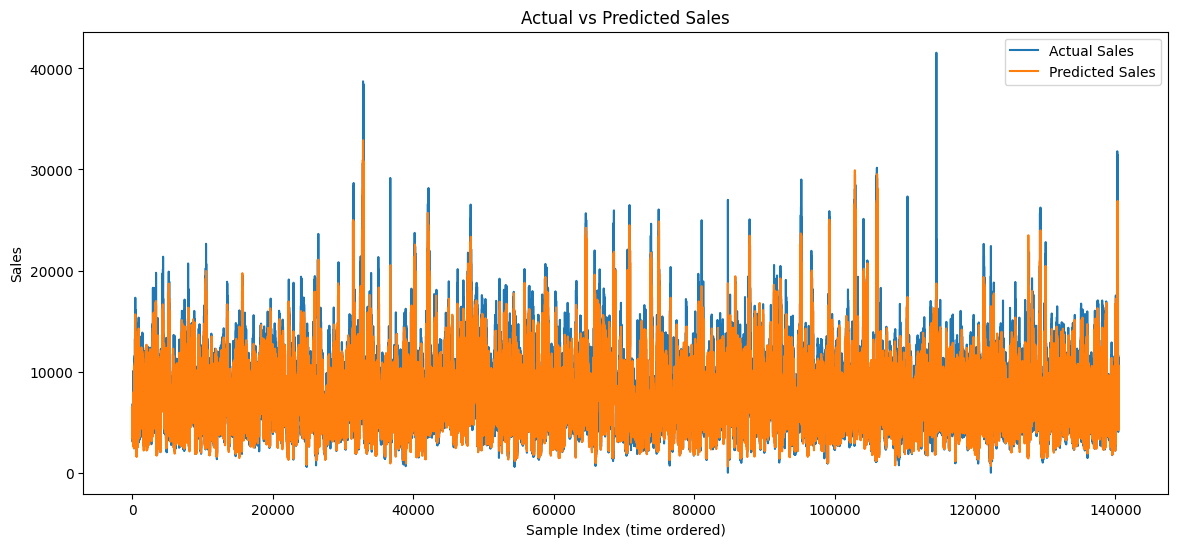

In [39]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.values, label='Actual Sales')
    plt.plot(y_pred, label='Predicted Sales')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Sample Index (time ordered)')
    plt.ylabel('Sales')
    plt.legend()
    plt.savefig('actual_vs_predicted.png')
    plt.show()

n = len(y_test)

plot_actual_vs_predicted(y_test[:n], y_pred[:n])

In [18]:
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)